# Gas Sensor Array Drift Dataset

# Data Preprocessing

### To download the dataset run the two next cells

In [ ]:
%%capture
!pip install -U --no-cache-dir gdown --pre
!gdown --id 15SomUwl-FphoMRnAB5uWpUEB92RSsmWg

In [ ]:
!unzip driftdataset.zip

### If you already have the data set, define the path to the folder under the ״folder״ variable

In [ ]:
folder = r'driftdataset'

In [ ]:
%%capture
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import math
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [ ]:
def get_list_of_files(folder):
    """Returns a list with the files contained in that folder"""
    ls_files = os.listdir(folder)
    path_files = [os.path.join(folder, f) for f in ls_files]
    return path_files

def get_list_of_files_with_extension(folder, ext):
    """Returns a list with the files with the specified extension {ext} contained in that folder."""
    path_files = get_list_of_files(folder)
    ls_ext = [f for f in path_files if f.endswith(ext)]
    return ls_ext

class LoadDatFile:
    """
    This class aims to load a .dat files from UCI
    https://archive.ics.uci.edu/ml//datasets/Gas+Sensor+Array+Drift+Dataset
    , and returns a pandas.dataframe object
    :arg .dat file
    :return df
    """

    def __init__(self, file):
        self.file = file

    @property
    def batch_number(self):
        base = os.path.basename(self.file)
        name, ext = os.path.splitext(base)
        num = re.findall(r'\d+', name)[0]
        # num = num.zfill(2)
        return int(num)

    @property
    def df(self):
        df = pd.read_table(self.file, engine='python', sep='\s+\d+:', header=None)
        df['Batch ID'] = self.batch_number
        return df


class GasDataFrame:
    """ Process the .dat file to get all the information contained:
    - Gas, concentration and measures."""

    def __init__(self, file):
        self.file = file

    @property
    def df(self):
        df_raw = LoadDatFile(self.file).df
        return self._add_gas_info(df_raw)

    @staticmethod
    def _add_gas_info(df):
        df[['GAS', 'CONCENTRATION']] = df.iloc[:, 0].str.split(";", expand=True, )
        df.drop(df.columns[0], axis=1, inplace=True)
        df['GAS'] = df['GAS'].astype('int')
        df['CONCENTRATION'] = df['CONCENTRATION'].astype('float')
        return df


class LoadDatFolder:
    """
    This class aims to load all .dat files contained in a folder,
    gives each file a GasDataframe format and concats all in a pandas.dataframe object with
    :inputs: folder with many .dat files
    :return df
    """
    def __init__(self, folder):
        self.folder = folder

    @property
    def df(self):
        files = get_list_of_files_with_extension(self.folder, 'dat')
        df_full = pd.DataFrame()
        for f in files:
            dftemp = GasDataFrame(f).df
            df_full = df_full.append(dftemp)
        return df_full


def load_data():
    folder = r'driftdataset'
    df_gas = LoadDatFolder(folder).df

    #Rename sensor columns
    col_names_dict = {}
    i = 1
    for sensor in range(0, 15 + 1):
        for feature in range(0, 7 + 1):
            col_names_dict[i] = f'S{sensor}_{feature}'
            i = i + 1

    df_gas = df_gas.rename(columns=col_names_dict)
    return df_gas


def load_data_scaled():
    # Load data
    df = load_data()

    # init scaler
    sc = StandardScaler()

    # Scale only sensor data
    sensor_features = df.iloc[:, :128]
    sc.fit(sensor_features)
    data_sc = sc.transform(sensor_features)

    # Get the unscaled info
    info = df[['Batch ID', 'GAS', 'CONCENTRATION']].values

    # Merge scaled data and the info into a pandas dataframe.
    data = np.concatenate([data_sc, info], axis=1)
    df_sca_gas = pd.DataFrame(data, columns=df.columns)
    for col in ['GAS', 'Batch ID']:
        df_sca_gas[col] = df_sca_gas[col].astype('int').astype('category')
    return df_sca_gas

def calculate_bins_concentration(df):
    # Create ConcentrationCat column.
    df['ConcentrationCat'] = pd.cut(df['CONCENTRATION'], bins=range(0, 1000, 100))
    return df

In [ ]:
%%capture
ldf = LoadDatFolder(folder)
my_dataframe_full = ldf.df

my_df_scaled = load_data_scaled()

In [4]:
my_df_scaled.head()

,S0_0,S0_1,S0_2,S0_3,S0_4,S0_5,S0_6,S0_7,S1_0,S1_1,...,S15_1,S15_2,S15_3,S15_4,S15_5,S15_6,S15_7,Batch ID,GAS,CONCENTRATION
0,-0.719384,-0.410835,-0.729778,-0.737766,-0.631897,0.710165,0.658904,0.435660,-0.306677,-0.207739,...,-0.470412,-0.647487,-0.691855,-0.733789,0.474596,0.469108,0.344781,8,4,100.0
1,-0.707427,-0.360377,-0.722288,-0.734490,-0.634355,0.710053,0.658859,0.435665,-0.221189,-0.114928,...,-0.682438,-1.018030,-0.937225,-0.955470,0.838900,0.790296,0.495879,8,5,25.0
2,-0.717663,-0.403575,-0.728641,-0.738657,-0.640715,0.710786,0.660087,0.435797,-0.310632,-0.208073,...,-0.461756,-0.594531,-0.648661,-0.676953,0.455808,0.464431,0.332307,8,4,100.0
3,-0.707996,-0.355507,-0.722231,-0.734410,-0.643444,0.710600,0.659227,0.435487,-0.216970,-0.113396,...,-0.667512,-1.016171,-0.936062,-0.938893,0.838035,0.787387,0.483740,8,5,25.0
4,-0.719946,-0.410658,-0.730276,-0.740243,-0.630824,0.712442,0.660650,0.437885,-0.320666,-0.211425,...,-0.460219,-0.589473,-0.632788,-0.633494,0.463180,0.452910,0.303213,8,4,100.0


In [5]:
my_df_scaled.values.shape

(13910, 131)

## TimeSeriesKMeans 

In [6]:
X = my_df_scaled.iloc[:, :-3].values
y = my_df_scaled.iloc[:, -1].values

In [7]:
cluster_count_CONCENTRATION = len(set(y))
cluster_count_CONCENTRATION

59

### By 59 clusters (CONCENTRATION)

In [8]:
# Apply the TimeSeriesKMeans algorithm to the time series data
km = TimeSeriesKMeans(n_clusters=cluster_count_CONCENTRATION, metric="euclidean", max_iter=5, verbose=True, random_state=0)
labels_kmeans = km.fit_predict(X)

# Plot the data and the clusters
plot_count = math.ceil(math.sqrt(cluster_count_CONCENTRATION))

14.035 --> 10.577 --> 10.273 --> 10.118 --> 10.074 --> 


In [9]:
plot_count

8

In [10]:
km.cluster_centers_.shape

(59, 128, 1)

In [11]:
silhouette_score(X, labels_kmeans)

0.26869350275760984

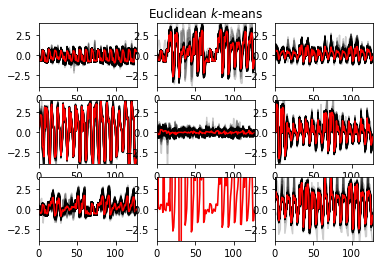

In [12]:
sz = X.shape[1]
plt.figure()
for yi in range(9):
    plt.subplot(3, 3, yi + 1)
    for xx in X[labels_kmeans == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("Euclidean $k$-means")

### By 6 clusters (GAS)

In [13]:
cluster_count_GAS = len(set(my_df_scaled.iloc[:, -2].values))
cluster_count_GAS

6

In [14]:
# Apply the TimeSeriesKMeans algorithm to the time series data
km_2 = TimeSeriesKMeans(n_clusters=cluster_count_GAS, metric="euclidean", max_iter=5, verbose=True, random_state=0)
labels_kmeans_2 = km_2.fit_predict(X)

# Plot the data and the clusters
plot_count_2 = math.ceil(math.sqrt(cluster_count_GAS))

77.418 --> 59.167 --> 57.426 --> 55.345 --> 54.397 --> 


In [15]:
plot_count_2

3

In [16]:
km_2.cluster_centers_.shape

(6, 128, 1)

In [17]:
silhouette_score(X, labels_kmeans_2)

0.3888199994966431

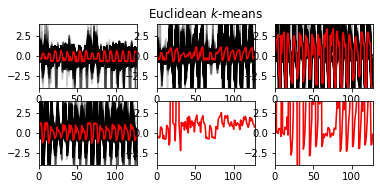

In [18]:
sz = X.shape[1]
plt.figure()
for yi in range(6):
    plt.subplot(3, 3, yi + 1)
    for xx in X[labels_kmeans_2 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km_2.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("Euclidean $k$-means")

## EM

We then create a GaussianMixture model with 5 components and fit it to the time series data using the fit method. We can then obtain the cluster labels for each time series using the predict method and the means and covariances of the components using the means_ and covariances_ attributes.

Note that in this example, we are using randomly generated data, but you can replace this with your own time series data. Additionally, you may need to tune the number of components depending on your specific use case.

### By 59 clusters (CONCENTRATION)

In [19]:
from sklearn.mixture import GaussianMixture
# Create a Gaussian Mixture model with 5 components
gmm = GaussianMixture(n_components=cluster_count_CONCENTRATION, random_state=0)

# Fit the model to the time series data
gmm.fit(X)

# Get the cluster labels for each time series
labels_em = gmm.predict(X)

# Get the means and covariances of the components
means = gmm.means_
covariances = gmm.covariances_

In [20]:
silhouette_score(X, labels_em)

0.20026249885994818

### By 6 clusters (GAS)

In [21]:
from sklearn.mixture import GaussianMixture
# Create a Gaussian Mixture model with 5 components
gmm_2 = GaussianMixture(n_components=cluster_count_GAS, random_state=0)

# Fit the model to the time series data
gmm_2.fit(X)

# Get the cluster labels for each time series
labels_em_2 = gmm_2.predict(X)

# Get the means and covariances of the components
means_2 = gmm_2.means_
covariances_2 = gmm_2.covariances_

In [22]:
silhouette_score(X, labels_em_2)

0.2657038746496726

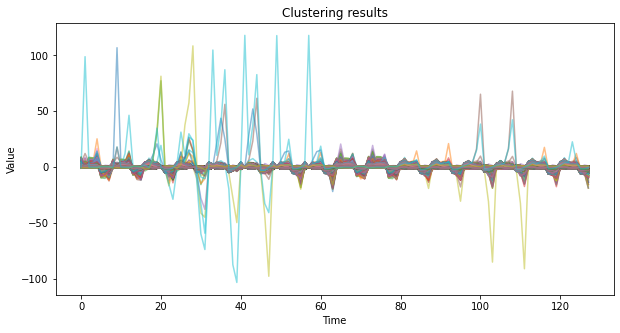

In [30]:
import matplotlib.pyplot as plt
# Create a line plot of the time series data and the clustering results
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(np.max(labels_am) + 1):
    ax.plot(X[labels_am_2 == i].T, alpha=0.5)

# Set the x and y axis labels
ax.set_xlabel("Time")
ax.set_ylabel("Value")

# Set the title of the plot
ax.set_title("Clustering results")

# Show the plot
plt.show()

## Hierarchical Clustering

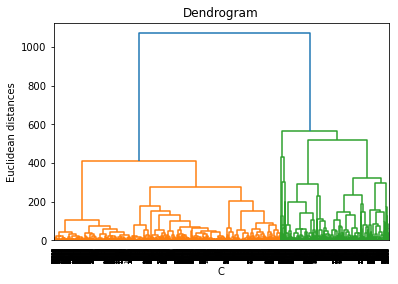

In [31]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('C')
plt.ylabel('Euclidean distances')
plt.show()

### By 59 clusters (CONCENTRATION)

In [32]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = cluster_count_CONCENTRATION, affinity = 'euclidean', linkage = 'ward')
labels_hc = hc.fit_predict(X)

In [33]:
silhouette_score(X, labels_hc)

0.27034538075491393

### By 6 clusters (GAS)

In [34]:
from sklearn.cluster import AgglomerativeClustering
hc_2 = AgglomerativeClustering(n_clusters = cluster_count_GAS, affinity = 'euclidean', linkage = 'ward')
labels_hc_2 = hc_2.fit_predict(X)

In [35]:
silhouette_score(X, labels_hc_2)

0.21705464840545205

## DBSCAN

In [35]:
from sklearn.cluster import DBSCAN
# eps is epsilon the starting point, and min_samples is the minimum points that must
# exist for cluster to be formed
dbscan = DBSCAN(eps=7.5, min_samples=(14000/1400)).fit(X)
labels_db = dbscan.labels_

# Print the data and the number of clusters
print(f'The number of clusters is: {len(set(labels_db))}')

The number of clusters is: 6


In [36]:
silhouette_score(X, labels_db)

0.210886578182532

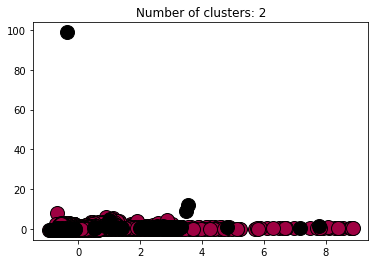

In [38]:
import numpy as np
unique_labels = set(labels_db)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # noise points in black
    class_member_mask = (labels_db == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    plt.title('Number of clusters: {}'.format(6))

plt.show()

In [ ]:
import numpy as np
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # noise points in black
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    plt.title('Number of clusters: {}'.format(2))

plt.show()

# Anomaly detection using Isolation Forest

In [39]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1)
isolation_forest.fit(X)
inliers_X = X[isolation_forest.predict(X) == 1]
inliers_y = y[isolation_forest.predict(X) == 1]
inliers_X.shape

(12519, 128)

# Kmeans without Anomalies

In [40]:
km_2 = TimeSeriesKMeans(n_clusters=cluster_count_GAS, metric="euclidean", max_iter=5, verbose=True, random_state=0)
labels_kmeans_2 = km_2.fit_predict(inliers_X)

# Plot the data and the clusters
plot_count_2 = math.ceil(math.sqrt(cluster_count_GAS))

27.604 --> 20.135 --> 19.733 --> 19.505 --> 19.329 --> 


In [41]:
silhouette_score(inliers_X, labels_kmeans_2)

0.2750285657494696

# EM without Anomalies

In [42]:
from sklearn.mixture import GaussianMixture
# Create a Gaussian Mixture model with 5 components
gmm = GaussianMixture(n_components=cluster_count_GAS, random_state=0)

# Fit the model to the time series data
gmm.fit(inliers_X)

# Get the cluster labels for each time series
labels_em = gmm.predict(inliers_X)

# Get the means and covariances of the components
means = gmm.means_
covariances = gmm.covariances_

In [43]:
silhouette_score(inliers_X, labels_em)

0.10715680671139143

# Hierarchical Clustering (without Anomalies)

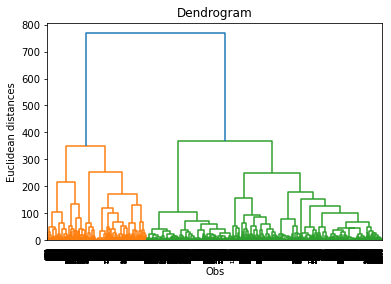

In [44]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(inliers_X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Obs')
plt.ylabel('Euclidean distances')
plt.show()

In [47]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = cluster_count_GAS, affinity = 'euclidean', linkage = 'ward')
labels_hc = hc.fit_predict(inliers_X)

In [48]:
silhouette_score(inliers_X, labels_hc)

0.22841793004836564

# DBSCAN (without Anomalies)

In [58]:
from sklearn.cluster import DBSCAN
# eps is epsilon the starting point, and min_samples is the minimum points that must
# exist for cluster to be formed
dbscan = DBSCAN(eps=4, min_samples=8).fit(inliers_X)
labels = dbscan.labels_

# Print the data and the number of clusters
print(f'The number of clusters is: {len(set(labels))}')

The number of clusters is: 6


In [59]:
silhouette_score(inliers_X, labels)

0.1682940576020758

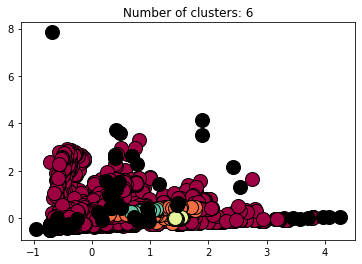

In [67]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # noise points in black
    class_member_mask = (labels == k)
    xy = inliers_X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    plt.title('Number of clusters: {}'.format(6))

plt.show()

# PCA

In [61]:
X = my_df_scaled.iloc[:, :-3].values
y = my_df_scaled.iloc[:, -2].values

In [62]:
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

In [63]:
y = skl.preprocessing.LabelEncoder().fit_transform(y)

((13910, 2), (13910,))

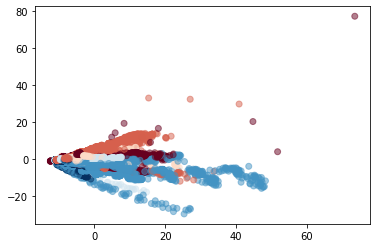

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [ ]:
set(y)

{0, 1, 2, 3, 4, 5}

# KMEANS with PCA


### PCA KMEANS with 6 clusters

In [ ]:
km_pca = KMeans(n_clusters = cluster_count_GAS, random_state = 0)
labels_kmeans_pca = km_pca.fit_predict(X)

In [ ]:
silhouette_score(X, labels_kmeans_pca)

0.37883745548504083

### PCA KMEANS with 2 clusters

In [ ]:
km_pca_2 = KMeans(n_clusters = 2, random_state = 0)
labels_kmeans_pca_2 = km_pca_2.fit_predict(X)

In [ ]:
silhouette_score(X, labels_kmeans_pca_2)

0.5175918044152669

In [ ]:
# Get the cluster labels and centers
labels_lb = km_pca_2.labels_
centers_pca2 = km_pca_2.cluster_centers_

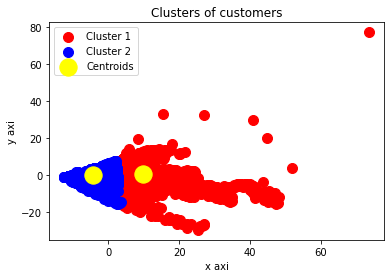

In [ ]:
plt.scatter(X[labels_kmeans_pca_2 == 0, 0], X[labels_kmeans_pca_2 == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[labels_kmeans_pca_2 == 1, 0], X[labels_kmeans_pca_2 == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(centers_pca2[:, 0], centers_pca2[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('x axi')
plt.ylabel('y axi')
plt.legend()
plt.show()

# EM with PCA

### PCA EM with 6 clusters

In [ ]:
from sklearn.mixture import GaussianMixture
# Create a Gaussian Mixture model with 5 components
gmm_pca = GaussianMixture(n_components=cluster_count_GAS, random_state=0)

# Fit the model to the time series data
gmm_pca.fit(X)

# Get the cluster labels for each time series
labels_em_pca = gmm_pca.predict(X)

# Get the means and covariances of the components
means = gmm_pca.means_
covariances = gmm_pca.covariances_

In [ ]:
silhouette_score(X, labels_em_pca)

0.3283427515398727

### PCA EM with 2 clusters

In [ ]:
# Create a Gaussian Mixture model with 5 components
gmm_pca_2 = GaussianMixture(n_components=2, random_state=0)

# Fit the model to the time series data
gmm_pca_2.fit(X)

# Get the cluster labels for each time series
labels_em_pca_2 = gmm_pca_2.predict(X)

# Get the means and covariances of the components
means = gmm_pca_2.means_
covariances = gmm_pca_2.covariances_

In [ ]:
silhouette_score(X, labels_em_pca_2)

0.43325110541694456

# EM with alternating maximization (after PCA)

In [ ]:
# Initialize cluster centers randomly
centers = np.random.randn(2, X.shape[1])

# Run the Expectation-Maximization algorithm with alternating maximization
for i in range(10):
    # Expectation step
    dist = np.linalg.norm(X[:, np.newaxis, :] - centers, axis=2)
    membership = np.argmin(dist, axis=1)
    
    # Maximization step
    for j in range(2):
        centers[j] = np.mean(X[membership == j], axis=0)

In [ ]:
silhouette_score(X, membership)

0.510946418442895

# Hierarchical Clustering With PCA


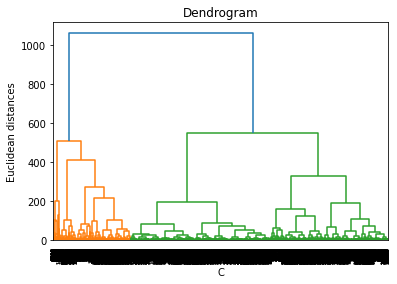

In [ ]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('C')
plt.ylabel('Euclidean distances')
plt.show()

### PCA Hierarchical Clustering with 6 clusters

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc_pca = AgglomerativeClustering(n_clusters = cluster_count_GAS, affinity = 'euclidean', linkage = 'ward')
labels_hc_pca = hc_pca.fit_predict(X)

In [ ]:
silhouette_score(X, labels_hc_pca)

0.3990997401406666

### PCA Hierarchical Clustering with 2 clusters

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc_pca_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
labels_hc_pca_2 = hc_pca_2.fit_predict(X)

In [ ]:
silhouette_score(X, labels_hc_pca_2)

0.5185865678994265

## DBSCAN with PCA

In [64]:
from sklearn.cluster import DBSCAN
# eps is epsilon the starting point, and min_samples is the minimum points that must
# exist for cluster to be formed
dbscan = DBSCAN(eps=3, min_samples=5).fit(X)
labels_db = dbscan.labels_

# Print the data and the number of clusters
print(f'The number of clusters is: {len(set(labels_db))}')

The number of clusters is: 2


In [65]:
silhouette_score(X, labels_db)

0.7361861794784885

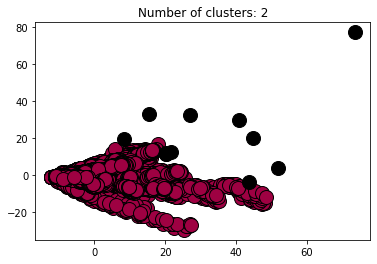

In [66]:
unique_labels = set(labels_db)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # noise points in black
    class_member_mask = (labels_db == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    plt.title('Number of clusters: {}'.format(2))

plt.show()